# LightGBM 

## 1. Import packages, loading and spliting data

In [1]:
import sys
sys.path.append("jupy_env/lib/python3.8/site-packages")
!export PATH=/Library/TeX/texbin:$PATH
import time
import lightgbm as lgb
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline


In [23]:
df = pd.read_csv("./data/SUSY.csv", header=None)

In [24]:
columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

df.columns = columns
df.head(5)

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [25]:
X = df.iloc[:,1:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
X_train_low = X_train.iloc[:,0:8]
X_train_high = X_train.iloc[:,8:]
X_test_low = X_test.iloc[:,0:8]
X_test_high = X_test.iloc[:,8:]

## 2. First look to the hyper-parameters

In [ ]:
estimator = LGBMClassifier(boosting_type = "gbdt", objective = "binary",
                           random_state=0, n_estimators = 100, num_leaves = 31, 
                           max_depth = 10, learning_rate = 0.1,
                           max_bin = 500, metric = "auc"
                          )

estimator.get_params()

### 2.1 Boosting Type
The boosting type can be chosen to be 
1. "gbdt" -- traditional Gradient Boosting Decision Tree
2. "dart" -- Dropouts meet Multiple Additive Regression Trees
3. "goss" -- Gradient-based One-Side Sampling 
4. "rf" -- Random Forest.

Due to time issue, I will focus on gradient boosting method and so only 1 boosting type will use.

### 2.2 class_weight in LGBMClassifier

The class_weight parameters can be set to "is_unbalance" and "scale_pos_weight" in a binary classfication problem. The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. To see which mode to use, 

In [27]:
print(y_train.value_counts())
print(y_test.value_counts())

0.0    2170404
1.0    1829596
Name: signal, dtype: int64
0.0    541769
1.0    458231
Name: signal, dtype: int64


The number of class 0 and class 1 are roughly the same, thus later the default value "None" will be used in the parameter "class weight" to ensure that the weight of each sample to be 1. 

### 2.3 n_estimators and learning_rate

The idea of boosting method is to iteratively build a new tree, "add" it to the original tree to correct the mis-classification in the previous step. The pararmeter n_estimators refer to the number of boosting tree in this iterative process. The learning_rate parameter controls the step size at each iteration while the loss-function approaches minima. To increase the accuracy, one should find the best combination of n_estimators and learning_rate. But intuitively a slower learning_rate means more accurate result as it runs all the points in the curve to find the minimum point. 

### 2.4 num_leaves and max_depth

For these two parameters, I quote the description on the user manual of lightGBM.

Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). 

Hence, these two parameters will be determined using cross validation. 

### 2.5 metric

For binary classification problem, I followed the papar to use "auc" as the function to characterize the performance of the model in each iteration. One can invoke an additional parameter "early-stopping" to stop the training if the value of "auc" does not improve over a number of iterations. 

### 2.6 max_bins

In lightGBM, the predictors distribution is not considered as continuous as in the usual boosting method. Instead, these distribution is treated as histogram and thus a maximum number of bins has to be set in advance. A high value of binning will potentially lead to over-fitting and a small value of binning will reduce the model to a continuous one, which would be much slower. (Side note: the use of histogram is natural in particle physics and nuclear physics) For starters, I will try to use the default value 255. 

## 3. Trial analysis on the use of low-level, high-level and all predictors

Initially, only the low-level predictors, which refer to the raw data measured by the detector (after converting signal to meaning quantities), are used in the analysis. However, there are no physics argument to link the source of the signal to these physical observables. As a result, the best we can do is to construct new observables based on the existing one and hoping that the response (y) would be sensitive to this new observables. As an example, the strength of electric force depends on the absolute distance between two points. If the raw data is the x,y,z coordinates of these two points, then we can easily calculate $r^2=x^2+y^2+z^2$ which immediates shows the expected relation.

Here, I follow the analysis in the paper and train the model in 3 cases:
1. Use low-level predictors (first 8)
2. Use high-level predictors (last 10)
3. Use all predictors

The author of the paper performs the analysis using deep learning and show that the result obtained by low-level is similar to that using all predictors. It is because the hidden layers in deep learning performs a similar job as constructing high-level predictors.

In this study, I expect to see the best performance on the analysis using all predictors as there are no hidden layer here and thus all predictors provide the most information.


In [7]:
estimator_low = LGBMClassifier(boosting_type = "gbdt", objective = "binary", 
                               random_state=0, n_estimators = 100, num_leaves = 31, 
                               max_depth = 10, learning_rate = 0.1,
                               max_bin = 255, metric = "auc"
                              )

estimator_high = LGBMClassifier(boosting_type = "gbdt", objective = "binary", 
                               random_state=0, n_estimators = 100, num_leaves = 31, 
                               max_depth = 10, learning_rate = 0.1,
                               max_bin = 255, metric = "auc"
                              )

estimator_all = LGBMClassifier(boosting_type = "gbdt", objective = "binary", 
                               random_state=0, n_estimators = 100, num_leaves = 31, 
                               max_depth = 10, learning_rate = 0.1,
                               max_bin = 255, metric = "auc"
                              )

### 3.1 Using low-level features

In [8]:
start_time = time.time()

estimator_low = estimator_low.fit(X_train_low, y_train)

training_time_low = time.time() - start_time

print("--- %s seconds ---" % (training_time_low))

y_pred_low = estimator_low.predict(X_test_low)
y_prob_low = estimator_low.predict_proba(X_test_low)
table_low = confusion_matrix(y_test, y_pred_low)
table_low

--- 345.41710138320923 seconds ---


array([[467067,  74702],
       [137064, 321167]])

In [9]:
accuracy_low = accuracy_score(y_pred_low, y_test)
print(accuracy_low)
roc_low = roc_auc_score(y_test, y_prob_low[:,1])
print(roc_low)
print(estimator_low.feature_importances_)
print(estimator_low.feature_name_)

0.788234
0.8608757743142309
[674 641  24 422 604  48 549  38]
['lepton_1_pT', 'lepton_1_eta', 'lepton_1_phi', 'lepton_2_pT', 'lepton_2_eta', 'lepton_2_phi', 'missing_energy_magnitude', 'missing_energy_phi']


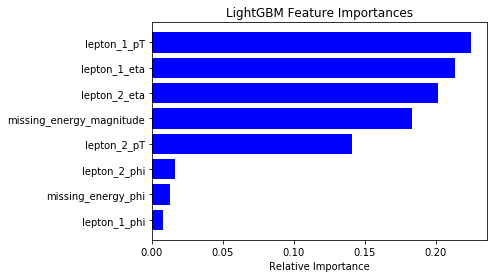

In [10]:
indices = np.argsort(estimator_low.feature_importances_)
plt.title('LightGBM Feature Importances')
plt.barh(range(len(indices)), estimator_low.feature_importances_[indices]/sum(estimator_low.feature_importances_), color='b', align='center')
plt.yticks(range(len(indices)), [estimator_low.feature_name_[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 3.2 Using high-level features

In [11]:
start_time = time.time()

estimator_high = estimator_high.fit(X_train_high, y_train)

training_time_high = time.time() - start_time

print("--- %s seconds ---" % (training_time_high))

y_pred_high = estimator_high.predict(X_test_high)
y_prob_high = estimator_high.predict_proba(X_test_high)
table_high = confusion_matrix(y_test, y_pred_high)
table_high

--- 405.25259923934937 seconds ---


array([[470474,  71295],
       [136102, 322129]])

In [12]:
accuracy_high = accuracy_score(y_pred_high, y_test)
print(accuracy_high)
roc_high = roc_auc_score(y_test, y_prob_high[:,1])
print(roc_high)
print(estimator_high.feature_importances_)
print(estimator_high.feature_name_)

0.792603
0.8633505349968046
[359 656 148 302 282 327 119 248 326 233]
['MET_rel', 'axial_MET', 'M_R', 'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


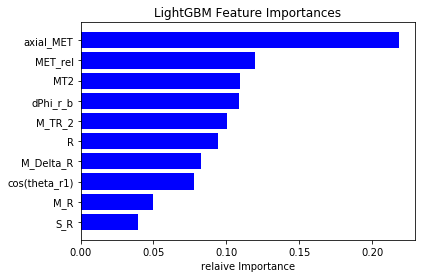

In [13]:
indices = np.argsort(estimator_high.feature_importances_)
plt.title('LightGBM Feature Importances')
plt.barh(range(len(indices)), estimator_high.feature_importances_[indices]/sum(estimator_high.feature_importances_), color='b', align='center')
plt.yticks(range(len(indices)), [estimator_high.feature_name_[i] for i in indices])
plt.xlabel('relaive Importance')
plt.show()

### 3.3 Using all features

In [14]:
start_time = time.time()

estimator_all = estimator_all.fit(X_train, y_train)

training_time_all = time.time() - start_time

print("--- %s seconds ---" % (training_time_all))

y_pred_all = estimator_all.predict(X_test)
y_prob_all = estimator_all.predict_proba(X_test)
table_all = confusion_matrix(y_test, y_pred_all)
table_all

--- 384.40007424354553 seconds ---


array([[473039,  68730],
       [129010, 329221]])

In [15]:
accuracy_all = accuracy_score(y_pred_all, y_test)
print(accuracy_all)
roc_all = roc_auc_score(y_test, y_prob_all[:,1])
print(roc_all)
print(estimator_all.feature_importances_)
print(estimator_all.feature_name_)

0.80226
0.875505000377846
[232 302   0  89 234   0 356   0 178 388 120 116  86 244 182 170 220  83]
['lepton_1_pT', 'lepton_1_eta', 'lepton_1_phi', 'lepton_2_pT', 'lepton_2_eta', 'lepton_2_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'MET_rel', 'axial_MET', 'M_R', 'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


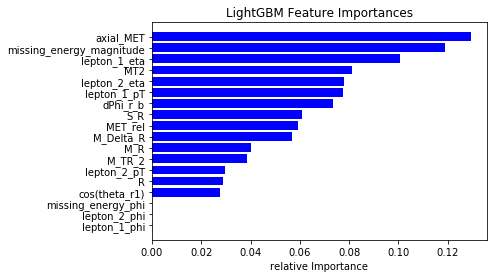

In [16]:
indices = np.argsort(estimator_all.feature_importances_)
plt.title('LightGBM Feature Importances')
plt.barh(range(len(indices)), estimator_all.feature_importances_[indices]/sum(estimator_all.feature_importances_), color='b', align='center')
plt.yticks(range(len(indices)), [estimator_all.feature_name_[i] for i in indices])
plt.xlabel('relative Importance')
plt.show()

/home/kin/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


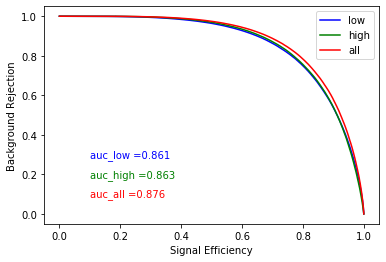

In [17]:


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob_all[:,1])
roc_auc = metrics.auc(fpr, tpr)

fpr_low, tpr_low, thresholds_low = metrics.roc_curve(y_test, y_prob_low[:,1])
roc_auc_low = metrics.auc(fpr_low, tpr_low)

fpr_high, tpr_high, thresholds_high = metrics.roc_curve(y_test, y_prob_high[:,1])
roc_auc_high = metrics.auc(fpr_high, tpr_high)


plt.plot(np.asarray(tpr_low),1-np.asanyarray(fpr_low), label="low", color="blue", )
plt.plot(np.asarray(tpr_high),1-np.asanyarray(fpr_high), label="high", color="green")
plt.plot(np.asarray(tpr),1-np.asanyarray(fpr), label="all", color="red")

plt.text(0.1, 0.3, "auc_low ={auc:.3f}".format(auc=roc_low), horizontalalignment='left',
         verticalalignment='center', color="blue")
plt.text(0.1, 0.2, "auc_high ={auc:.3f}".format(auc=roc_high), horizontalalignment='left',
         verticalalignment='center', color="green")
plt.text(0.1, 0.1, "auc_all ={auc:.3f}".format(auc=roc_all), horizontalalignment='left',
         verticalalignment='center', color="red")

plt.xlabel("Signal Efficiency")
plt.ylabel("Background Rejection")
plt.legend()
plt.show()


## 4. Parameter tunning 

### 4.1 Tunning num_leaves and max_depth

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

estimator = LGBMClassifier(boosting_type = "gbdt", objective = "binary", 
                           random_state=0, n_estimators = 100, metric = "auc"
                          )

In [32]:
#"learning_rate": [0.01,0.1,0.5], "n_estimators": [100, 300],
grid_params = {
                   
                   "num_leaves": [5,10,15], "max_depth": [10,12,20]
              }

In [33]:
start_time = time.time()
grid = GridSearchCV(estimator, param_grid=grid_params, verbose=4, cv=5, n_jobs=-4)
grid.fit(X_train, y_train)
grid_time = time.time() - start_time
print("--- %s seconds ---" % (grid_time))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-4)]: Done  15 tasks      | elapsed:  3.8min


[CV] max_depth=10, num_leaves=5 ......................................
[CV] .......... max_depth=10, num_leaves=5, score=0.797, total= 1.1min
[CV] max_depth=10, num_leaves=10 .....................................
[CV] ......... max_depth=10, num_leaves=10, score=0.800, total= 1.2min
[CV] max_depth=10, num_leaves=15 .....................................
[CV] ......... max_depth=10, num_leaves=15, score=0.801, total= 1.4min
[CV] max_depth=12, num_leaves=5 ......................................
[CV] .......... max_depth=12, num_leaves=5, score=0.797, total=  57.7s


/usr/lib/python3/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] max_depth=10, num_leaves=5 ......................................
[CV] .......... max_depth=10, num_leaves=5, score=0.797, total=  52.7s
[CV] max_depth=10, num_leaves=10 .....................................
[CV] ......... max_depth=10, num_leaves=10, score=0.800, total= 1.3min
[CV] max_depth=10, num_leaves=15 .....................................
[CV] ......... max_depth=10, num_leaves=15, score=0.801, total= 1.5min
[CV] max_depth=12, num_leaves=5 ......................................
[CV] .......... max_depth=12, num_leaves=5, score=0.797, total=  55.1s
[CV] max_depth=12, num_leaves=10 .....................................
[CV] ......... max_depth=12, num_leaves=10, score=0.800, total=  59.3s
[CV] max_depth=12, num_leaves=15 .....................................
[CV] ......... max_depth=12, num_leaves=15, score=0.801, total= 1.1min
[CV] max_depth=20, num_leaves=5 ......................................
[CV] .......... max_depth=20, num_leaves=5, score=0.797, total=  46.8s


[Parallel(n_jobs=-4)]: Done  45 out of  45 | elapsed: 10.5min finished


--- 666.7099778652191 seconds ---
[CV] max_depth=12, num_leaves=10 .....................................
[CV] ......... max_depth=12, num_leaves=10, score=0.800, total= 1.3min
[CV] max_depth=12, num_leaves=15 .....................................
[CV] ......... max_depth=12, num_leaves=15, score=0.800, total= 1.1min
[CV] max_depth=20, num_leaves=10 .....................................
[CV] ......... max_depth=20, num_leaves=10, score=0.800, total= 1.1min
[CV] max_depth=20, num_leaves=15 .....................................
[CV] ......... max_depth=20, num_leaves=15, score=0.801, total= 1.2min
[CV] max_depth=20, num_leaves=10 .....................................
[CV] ......... max_depth=20, num_leaves=10, score=0.800, total= 1.0min
[CV] max_depth=20, num_leaves=15 .....................................
[CV] ......... max_depth=20, num_leaves=15, score=0.801, total= 1.3min
[CV] max_depth=10, num_leaves=5 ......................................
[CV] .......... max_depth=10, num_leaves=5,

In [34]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 10, 'num_leaves': 15}
0.80110025


Running CV search, it is seen that the best combination of the parameters "max_depth" and "num_leaves" is 10 and 15 respectively. Because of the runtime issue, the CV search for best hyperparameters will be divided in several steps. First serach for "max_depth" and "num_leaves", then use the best combination of this two hyperparameters and search for the best of other parameters.

In [35]:
refined_estimator = LGBMClassifier(boosting_type = "gbdt", objective = "binary", 
                           random_state=0, metric = "auc", 
                           max_depth = 10, num_leaves = 15
                          )

In [36]:
grid_params = {
                   
                   "learning_rate": [0.01,0.1,0.5], "n_estimators": [100, 200, 300],
              }

In [37]:
start_time = time.time()
refined_grid = GridSearchCV(refined_estimator, param_grid=grid_params, verbose=4, cv=5, n_jobs=-4)
refined_grid.fit(X_train, y_train)
grid_time = time.time() - start_time
print("--- %s seconds ---" % (grid_time))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 5 concurrent workers.


[CV] learning_rate=0.01, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=100, score=0.785, total= 1.2min
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, score=0.792, total= 2.4min


/usr/lib/python3/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] learning_rate=0.01, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=100, score=0.785, total= 1.5min
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, score=0.792, total= 2.2min
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=100, score=0.784, total= 1.2min
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, score=0.792, total= 2.2min
[CV] learning_rate=0.01, n_estimators=300 ............................
[CV]  learning_rate=0.01, n_estimators=300, score=0.795, total= 3.1min


[Parallel(n_jobs=-4)]: Done  15 tasks      | elapsed:  7.9min


[CV] learning_rate=0.01, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=100, score=0.784, total= 1.2min
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, score=0.792, total= 2.7min
[CV] learning_rate=0.01, n_estimators=300 ............................
[CV]  learning_rate=0.01, n_estimators=300, score=0.795, total= 4.4min
[CV] learning_rate=0.01, n_estimators=300 ............................
[CV]  learning_rate=0.01, n_estimators=300, score=0.795, total= 4.0min
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] . learning_rate=0.1, n_estimators=100, score=0.801, total= 1.1min
[CV] learning_rate=0.1, n_estimators=200 .............................
[CV] . learning_rate=0.1, n_estimators=200, score=0.802, total= 1.9min
[CV] learning_rate=0.1, n_estimators=300 .............................
[CV] . learning_rate=0.1, n_estimators=300, score=0.803, total= 2.6min


[Parallel(n_jobs=-4)]: Done  45 out of  45 | elapsed: 18.5min finished


--- 1163.2760672569275 seconds ---
[CV] learning_rate=0.01, n_estimators=300 ............................
[CV]  learning_rate=0.01, n_estimators=300, score=0.795, total= 3.0min
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] . learning_rate=0.1, n_estimators=100, score=0.801, total= 1.2min
[CV] learning_rate=0.1, n_estimators=200 .............................
[CV] . learning_rate=0.1, n_estimators=200, score=0.802, total= 2.9min
[CV] learning_rate=0.1, n_estimators=300 .............................
[CV] . learning_rate=0.1, n_estimators=300, score=0.803, total= 2.6min
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] . learning_rate=0.5, n_estimators=100, score=0.802, total= 1.1min
[CV] learning_rate=0.5, n_estimators=200 .............................
[CV] . learning_rate=0.5, n_estimators=200, score=0.802, total= 1.5min
[CV] learning_rate=0.5, n_estimators=300 .............................
[CV] . learning_rate=0.5, n_estimators=300

In [38]:
print(refined_grid.best_params_)
print(refined_grid.best_score_)

{'learning_rate': 0.1, 'n_estimators': 300}
0.8028879999999999


In [39]:
final_estimator = LGBMClassifier(boosting_type = "gbdt", objective = "binary", 
                           random_state=0, n_estimators = 300, metric = "auc",
                            learning_rate=0.1, max_depth = 10, num_leaves = 15
                          )

In [40]:
start_time = time.time()
final_estimator = final_estimator.fit(X_train, y_train)

training_time = time.time() - start_time

print("--- %s seconds ---" % (training_time))

y_pred = final_estimator.predict(X_test)
y_prob = final_estimator.predict_proba(X_test)
table = confusion_matrix(y_test, y_pred)
table

--- 50.65136504173279 seconds ---


array([[473899,  67870],
       [129117, 329114]])

In [42]:
accuracy_final = accuracy_score(y_pred, y_test)
print(accuracy_final)
roc_final = roc_auc_score(y_test, y_prob[:,1])
print(roc_final)
print(final_estimator.feature_importances_)
print(final_estimator.feature_name_)

0.803013
0.8762638462940171
[345 286  20 239 237  20 441  17 306 468 205 187 124 361 232 283 277 152]
['lepton_1_pT', 'lepton_1_eta', 'lepton_1_phi', 'lepton_2_pT', 'lepton_2_eta', 'lepton_2_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'MET_rel', 'axial_MET', 'M_R', 'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


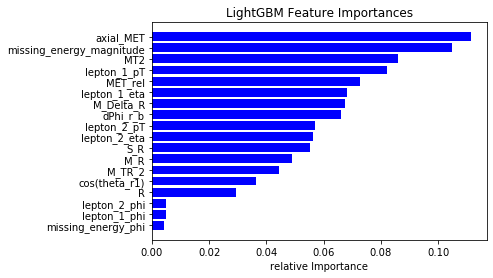

In [43]:
indices = np.argsort(final_estimator.feature_importances_)
plt.title('LightGBM Feature Importances')
plt.barh(range(len(indices)), final_estimator.feature_importances_[indices]/sum(final_estimator.feature_importances_), color='b', align='center')
plt.yticks(range(len(indices)), [final_estimator.feature_name_[i] for i in indices])
plt.xlabel('relative Importance')
plt.show()

The test error rate of the optimized lightGBM estimator is ~0.197, which is much smaller than that of parametric methods but comparable to lightGBM, XGBoost and other tree-based methods with default parameter setting. From the above plot it is seen that the most important predictors include 
1. axial MET
2. missing energy magnitude
3. MT2 
4. lepton 1 pT

which are slightly different than the prediction from XGBoost, but is overall consistent. Note also that the angles are predicted to be irrelevanet in lightGBM as well in XGBoost. So it is a strong evidence that the prediction of existence of exotic particle does not depend on the emission angle of the particle, which is expected in the $\phi$ angle we expect azimuthal symmetry. 

## 5. Conclusion and future work

1. Optimization of hyperparameters:
   In this work, the function GridSearchCV in the SkLearn library is used to find the best set of parameters. Although it only takes approximately 1 minute to train individual model, there are too many possible combinations of parameter which makes the total training time exceedingly long. To efficiently apply CV to select parameters, these procedures are performed in a sequentially so a lot of combinations are not tested. Therefore, it worth to spend more time on selecting parameters in a larger combination pool.
   
2. Deep Learning methods:
   In the original paper, the method of neural network, as well as deep learning are employed because of the similarity of using high-level predictors and the hidden layers. The paper attempted to use deep learning method so that in the future physicist would not have to invent new observable and play with the model in a way just as good as blind guess. Therefore, re-visit this study using deep learning method would be a good study.
   
3. In conclusion, parametric methods and tree-based methods are used to train the model in this study. It is found that lightGBM would be the most efficient and the test error rate drops to 0.197 after performing CV serach for the best parameters.